## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp
from tqdm import tqdm

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere

import sfacts as sf

from tqdm import tqdm

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
species_id = 102492

fit = sf.data.World.load(f'data/zshi.sp-{species_id}.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 0.05

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 11860, 'position': 3681, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(1.1444092e-05, dtype=float32)
Frozen(SortedKeysDict({'strain': 198, 'sample': 11860, 'position': 3681, 'allele': 2}))


In [29]:
ref = sf.data.Metagenotypes.load(f'data/gtprodb.sp-{species_id}.genotype.nc')
ref_genotypes = ref.mlift('sel', position=fit_genotypes.position).to_estimated_genotypes(pseudo=0)
ref_genotypes.sizes

Frozen({'strain': 1000, 'position': 3681})

In [24]:
position_meta = pd.read_table(
    'ref/gtpro/variants_main.covered.hq.snp_dict.tsv',
    names=['species_id', 'position', 'contig', 'contig_position', 'ref', 'alt']
).set_index('position')[lambda x: x.species_id.isin([species_id])]

position_meta

,species_id,contig,contig_position,ref,alt
position,,,,,
14092,102492,.12718_7_53.1,14092,A,G
14137,102492,.12718_7_53.1,14137,T,C
14668,102492,.12718_7_53.1,14668,A,G
15562,102492,.12718_7_53.1,15562,T,C
15564,102492,.12718_7_53.1,15564,C,T
...,...,...,...,...,...
3454569,102492,.12718_7_53.57,7365,A,C
3454572,102492,.12718_7_53.57,7368,C,G
3455438,102492,.12718_7_53.57,8234,G,A


In [31]:
fit_dist = fit_genotypes.discretized().pdist()
ref_dist = ref_genotypes.discretized().pdist()

In [34]:
dedup_thresh = 0.05

fit_dedup_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(fit_dist),
    index=fit_genotypes.strain.astype(int),
)
ref_dedup_clust = pd.Series(
    AgglomerativeClustering(
        distance_threshold=dedup_thresh, n_clusters=None, affinity='precomputed', linkage='average'
    ).fit_predict(ref_dist),
    index=ref_genotypes.strain,
)

In [36]:
fit_genotypes_dedup = sf.Genotypes(fit_genotypes.to_series().unstack('strain').groupby(fit_dedup_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [37]:
ref_genotypes_dedup = sf.Genotypes(ref_genotypes.to_series().unstack('strain').groupby(ref_dedup_clust, axis='columns').mean().rename(columns=lambda x: int(x)).rename_axis(columns='strain').T.stack().to_xarray())

In [38]:
(fit_genotypes.sizes['strain'], fit_genotypes_dedup.sizes['strain']), (ref_genotypes.sizes['strain'], ref_genotypes_dedup.sizes['strain'])

((198, 198), (1000, 752))

In [ ]:
_g_ref = ref_genotypes_dedup#.random_sample(position=20000)
r2_ref = (1 - pdist(_g_ref.values.T, 'correlation'))**2

_g_fit = fit_genotypes_dedup#.sel(position=_g_ref.position)
r2_fit = (1 - pdist(_g_fit.values.T, 'correlation'))**2

In [134]:
np.mean(r2_ref), np.mean(r2_fit)

(0.01171654808264688, 0.017961986997681312)

In [135]:
np.median(r2_ref), np.median(r2_fit)

(0.00234095548439049, 0.005040182212089999)

In [136]:
np.quantile(r2_ref, 0.9), np.quantile(r2_fit, 0.9)

(0.022544897916700616, 0.04028370549637712)

In [138]:
from scipy.stats import mannwhitneyu, wilcoxon

n = 10000
wilcoxon(r2_ref[:n], r2_fit[:n])

WilcoxonResult(statistic=17084664.0, pvalue=1.3385440094220457e-165)

In [39]:
ld = {}
for contig, pos in position_meta.loc[ref_genotypes_dedup.position].groupby('contig'):
    print(contig)
    g = ref_genotypes_dedup.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
ref_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

.12718_7_53.1
.12718_7_53.11
.12718_7_53.13
.12718_7_53.14
.12718_7_53.15
.12718_7_53.16
.12718_7_53.2
.12718_7_53.21
.12718_7_53.23
.12718_7_53.24
.12718_7_53.25
.12718_7_53.26
.12718_7_53.27
.12718_7_53.28
.12718_7_53.29
.12718_7_53.3
.12718_7_53.32
.12718_7_53.34
.12718_7_53.37
.12718_7_53.4
.12718_7_53.40
.12718_7_53.57
.12718_7_53.6
.12718_7_53.7
.12718_7_53.8
.12718_7_53.9


In [40]:
ld = {}
for contig, pos in position_meta.loc[fit_genotypes_dedup.position].groupby('contig'):
    print(contig)
    g = fit_genotypes_dedup.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
fit_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

.12718_7_53.1
.12718_7_53.11
.12718_7_53.13
.12718_7_53.14
.12718_7_53.15
.12718_7_53.16
.12718_7_53.2
.12718_7_53.21
.12718_7_53.23
.12718_7_53.24
.12718_7_53.25
.12718_7_53.26
.12718_7_53.27
.12718_7_53.28
.12718_7_53.29
.12718_7_53.3
.12718_7_53.32
.12718_7_53.34
.12718_7_53.37
.12718_7_53.4
.12718_7_53.40
.12718_7_53.57
.12718_7_53.6
.12718_7_53.7
.12718_7_53.8
.12718_7_53.9


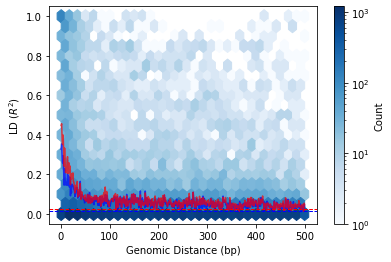

In [62]:
stepsize = 1
right = 500

d = fit_ld[lambda p: p.x < right]
bins_est = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()
    
    
d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()


fig = plt.figure()

plt.hexbin('x', 'r2', data=d, cmap='Blues', norm=mpl.colors.LogNorm(), mincnt=1, gridsize=(30, 10), label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.plot(pd.Series(bins_ref), color='blue', label=f'reference genotypes', alpha=0.7)
ax.plot(pd.Series(bins_est), color='red', label=f'inferred genotypes', alpha=0.7)

ax.axhline(np.mean(r2_ref), lw=1, color='blue', linestyle='--')
ax.axhline(np.mean(r2_fit), lw=1, color='red', linestyle='--')


# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')

fig.savefig(f'fig/ld_decay_{species_id}.png', dpi=400)

In [ ]:
stepsize = 1
right = 10000

d = fit_ld[lambda p: p.x < right]
bins_est = {}
for start in tqdm(range(1, right, stepsize)):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.quantile(0.9)

d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in tqdm(range(1, right, stepsize)):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.quantile(0.9)

In [232]:
quantile90 = pd.DataFrame(dict(ref=bins_ref, fit=bins_est)).rename_axis(index='distance').reset_index().assign(log_distance=lambda x: np.log(x.distance))
span = 0.5

rolling = {}
for i, log_distance in tqdm(list(quantile90.log_distance.iteritems())):
    rolling[i] = (
        quantile90[
            lambda x: True
            & (x.log_distance > log_distance - span / 2)
            & ((x.log_distance < log_distance + span / 2))
        ]
        [['ref', 'fit']]
        .mean()
    )
rolling = pd.DataFrame(rolling).T
quantile90 = quantile90.assign(ref_rolling=rolling['ref'], fit_rolling=rolling['fit'])

100%|██████████| 9999/9999 [00:13<00:00, 730.17it/s]


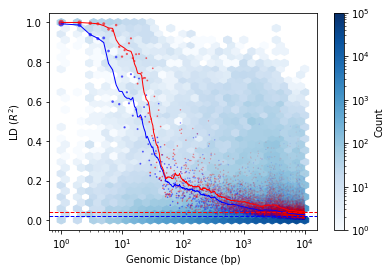

In [233]:
fig = plt.figure()

plt.hexbin('x', 'r2', data=fit_ld[lambda p: p.x < right], cmap='Blues', norm=mpl.colors.LogNorm(vmin=1, vmax=1e5), xscale='log', gridsize=30, mincnt=1, label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.scatter('distance', 'ref', data=quantile90.assign(s=lambda x: 20 / x['distance']), color='blue', label=f'reference genotypes', s='s', alpha=0.5)
ax.scatter('distance', 'fit', data=quantile90.assign(s=lambda x: 20 / x['distance']), color='red', label=f'inferred genotypes', s='s', alpha=0.5)

ax.plot('distance', 'ref_rolling', data=quantile90, lw=1, color='blue')
ax.plot('distance', 'fit_rolling', data=quantile90, lw=1, color='red')


ax.axhline(np.quantile(r2_ref, 0.9), lw=1, color='blue', linestyle='--')
ax.axhline(np.quantile(r2_fit, 0.9), lw=1, color='red', linestyle='--')

# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')

# fig.savefig(f'fig/ld_decay_{species_id}_90th.png', dpi=400)

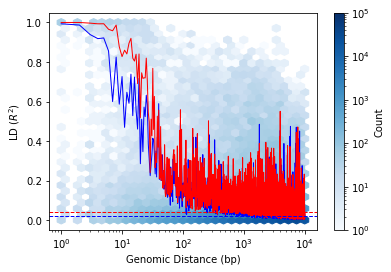

In [235]:
fig = plt.figure()

plt.hexbin('x', 'r2', data=fit_ld[lambda p: p.x < right], cmap='Blues', norm=mpl.colors.LogNorm(vmin=1, vmax=1e5), xscale='log', gridsize=30, mincnt=1, label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

# ax.scatter('distance', 'ref', data=quantile90.assign(s=lambda x: 20 / x['distance']), color='blue', label=f'reference genotypes', s='s', alpha=0.5)
# ax.scatter('distance', 'fit', data=quantile90.assign(s=lambda x: 20 / x['distance']), color='red', label=f'inferred genotypes', s='s', alpha=0.5)

ax.plot('distance', 'ref', data=quantile90, lw=1, color='blue')
ax.plot('distance', 'fit', data=quantile90, lw=1, color='red')


ax.axhline(np.quantile(r2_ref, 0.9), lw=1, color='blue', linestyle='--')
ax.axhline(np.quantile(r2_fit, 0.9), lw=1, color='red', linestyle='--')

# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')

# fig.savefig(f'fig/ld_decay_{species_id}_90th.png', dpi=400)

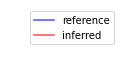

In [61]:
fig, ax = plt.subplots(figsize=(2, 1))

ax.plot([], color='blue', label=f'reference', alpha=0.7)
ax.plot([], color='red', label=f'inferred', alpha=0.7)
ax.legend()  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.axis('off')
fig.savefig(f'fig/ld_decay_{species_id}_legend.png', dpi=400)

In [440]:
nx, ny = 121, 51
xlim = np.array([0.5, 1e5])
ylim = np.array([0, 1])
xbins = np.unique(np.floor(np.logspace(*np.log10(xlim), num=51)).astype(int))
ybins = np.unique(np.linspace(*ylim, num=ny))

d = fit_ld#[fit_ld.x < 1e5]

hist, xedges, yedges = np.histogram2d(
    d['x'],
#     d['x'],
    d['r2'],
    bins=(xbins, ybins),
#     range=np.array([[np.min(xbins), np.max(xbins)], [np.min(ybins), np.max(ybins)]]),
)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
hist = pd.DataFrame(hist, columns=yedges[1:], index=xedges[:-1]).T
norm_hist = hist / hist.sum()

In [460]:
# TODO: Calculate the 90th percentile within the distance window from the histogram

out = []
for i, left in enumerate(xbins[:-1]):
    right = xbins[i + 1]
    out.append((
        left,
        right,
        fit_ld[(fit_ld.x > left) & (fit_ld.x <= right)].r2.quantile(0.9),
        ref_ld[(ref_ld.x > left) & (ref_ld.x <= right)].r2.quantile(0.9)
    ))
    
hist_bin_quantile90 = pd.DataFrame(out, columns=['left', 'right', 'fit', 'ref'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  This is separate from the ipykernel package so we can avoid doing imports until


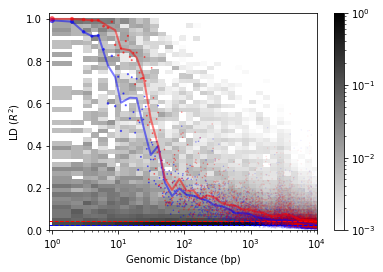

In [462]:
fig = plt.figure()

plt.pcolormesh(norm_hist.columns, norm_hist.index, norm_hist, norm=mpl.colors.LogNorm(vmin=1e-3, vmax=1.0), cmap='binary')
plt.xscale('log')
plt.colorbar()


ax = plt.gca()

ax.scatter('distance', 'ref', data=quantile90.assign(s=lambda x: 20 / x['distance']), color='blue', label=f'reference genotypes', s='s', alpha=0.5)
ax.scatter('distance', 'fit', data=quantile90.assign(s=lambda x: 20 / x['distance']), color='red', label=f'inferred genotypes', s='s', alpha=0.5)

ax.plot('right', 'ref', data=hist_bin_quantile90, lw=2, color='blue', alpha=0.5)
ax.plot('right', 'fit', data=hist_bin_quantile90, lw=2, color='red', alpha=0.5)


ax.axhline(np.quantile(r2_ref, 0.9), lw=1, color='blue', linestyle='--')
ax.axhline(np.quantile(r2_fit, 0.9), lw=1, color='red', linestyle='--')

# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')
ax.set_ylim(0, 1.03)
ax.set_xlim(0.9, 1e4)


fig.savefig(f'fig/ld_decay_{species_id}_90th.png', dpi=400)

In [393]:
quantile90.head(5)

,distance,ref,fit,log_distance,ref_rolling,fit_rolling
0,1,0.993112,0.999977,0.000000,0.993112,0.999977
1,2,0.986788,0.999799,0.693147,0.986788,0.999799
2,3,0.938437,0.996470,1.098612,0.938437,0.996470
3,4,0.918131,0.993071,1.386294,0.919871,0.993270
4,5,0.921612,0.993469,1.609438,0.898450,0.983975


In [265]:
np.quantile(r2_ref, 0.9), np.quantile(r2_fit, 0.9)

(0.022544897916700616, 0.04028370549637712)